# 线性回归的从零开始实现

In [62]:
%matplotlib inline
import torch
import random
import sys
import matplotlib.pyplot as plt

## 生成数据
X为随机生成的一组数据，符合正态分布，y为Xw+b的准确值，但是要在每个y上叠加一个小误差（噪声），噪声也同样符合正态分布。

In [ ]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w))) # 正态分布
    y = torch.matmul(X, w) + b # 矩阵乘法
    y += torch.normal(0, 0.01, y.shape) # 添加
    return X, y.reshape((-1, 1))

In [ ]:
# 设置种子
true_w = torch.tensor([5, -1.9])
true_b = 8.8
features, labels = synthetic_data(true_w, true_b, 1000)

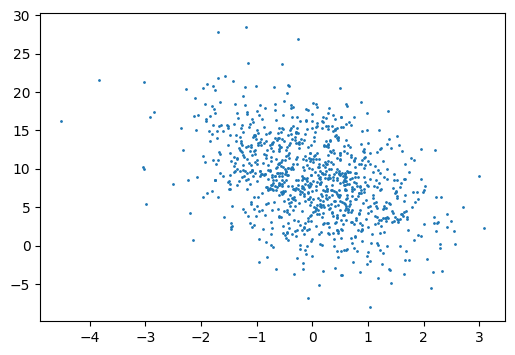

In [65]:
# 绘制散点图
plt.figure(figsize=(6, 4))
plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

## 读取数据集
data_iter是一个生成器，每次生成batch_size对数据，每对数据包含一个feature和一个label, yield的作用是将这组数据返回给迭代器，并中断函数的运行。下次运行时data_iter不从头开始，而是从上一次中断的地方继续开始。

In [66]:
# 批量生成数据的迭代器
# batch_size为每个batch的大小，features和labels为特征和标签
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples)) # 生成索引
    random.shuffle(indices) # 打乱数据集
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)]) # min有效处理不能整除的情况
        yield features[batch_indices], labels[batch_indices] # 每次返回一个batch

In [67]:
# 测试data_iter函数
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.1902,  0.7203],
        [-0.0084, -0.4721],
        [ 0.8181, -0.5415],
        [ 0.9991, -0.5544],
        [ 0.8146, -1.2885],
        [-1.0020,  0.8887],
        [ 0.4235,  0.0161],
        [ 1.5917, -1.9619],
        [ 1.6499,  0.1879],
        [ 0.6761,  0.4962]]) 
 tensor([[ 6.4736],
        [ 9.6595],
        [13.8983],
        [14.8588],
        [15.3097],
        [ 2.1119],
        [10.8975],
        [20.4848],
        [16.7040],
        [11.2434]])


## 初始化模型参数
将requires_grad设为true可以让我们通过自动微分来计算梯度。
将w初始化为均值为0，标准差为0.01的正态分布，b初始化为0。

In [68]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
# w不可初始化为零，否则梯度下降无法更新
# 这会导致所有样本梯度相同，无法打破对称性
b = torch.zeros(1, requires_grad=True)

## 定义模型
定义一个线性回归模型，将模型的输入和参数同模型的输出结合起来。

In [69]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

## 定义损失函数
因为我们要使得损失函数尽可能地小，所以我们需要定义损失函数。我们使用平方损失函数。在实现中，我们需要将真实值y的形状转换为和预测值y_hat的形状相同。

In [70]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 定义优化算法
在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。 接下来，朝着减少损失的方向更新我们的参数。

In [71]:
def sgd(params, lr, batch_size): 
    with torch.no_grad(): # 使用torch.no_grad()来禁用梯度计算，优化时不涉及到梯度
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 训练
在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。 计算完损失后，我们开始反向传播，存储每个参数的梯度。 最后，我们调用优化算法sgd来更新模型参数。
在每个迭代周期（epoch）中，我们使用data_iter函数遍历整个数据集， 并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。 这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设为3和0.03。

In [72]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.132644
epoch 2, loss 0.000415
epoch 3, loss 0.000052


由于我们知道真正的w和b是什么，因此我们可以进行验证：

In [73]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0010, -0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0007], grad_fn=<RsubBackward1>)
